# Data Sctructure and Importing
These functions execute the importing of files of type gpx and return a numpy array of dtype float (32 bits) with shape [n, 7], containing a list of GPS coordination points, each containing latitude, longitude and other 5 facts. The length 0 of the array is the number of n points observations.

Functions:

    import_gpxs(path, maxfiles=0, rider=0)
    import_gpx(filepath)
    
Both return an numpy array [n, 7] of float32 values:

    0 latitude number from -180 to +180 in degrees
    1 longitude number from -90 to +90 in degrees
    2 elevation number in meters
    3 time in UTC timestamp
    4 point number index on track
    5 track number index on rider
    6 rider number index

In [183]:
# import needed packages
import gpxpy
import datetime 
import time
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import numpy as np
import re
import sys
import pandas as pd
import pickle as pk
from tqdm import tqdm_notebook as tqdm
from copy import deepcopy
from geopy.distance import vincenty
from geopy.distance import great_circle
from scipy.signal import gaussian
from scipy.ndimage import filters

In [3]:
# load the gpx data
gpx_filename_pattern = re.compile("(gpx)$")

def build_meta(gpx): 
    meta = {
        "tracks": 0,
        "segments": 0,
        "points": 0
    }
    for track in gpx.tracks:
        meta["tracks"] += 1
        for segment in track.segments:
            meta["segments"] += 1
            for point in segment.points:
                meta["points"] += 1
    return meta

def import_gpx_file(path, filename):
    build_meta
    file = open(path+'/'+filename, 'r')
    gpx = gpxpy.parse(file)
    meta = build_meta(gpx)
    data = np.zeros((meta['points'], 5))
    n = 0
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                t = time.mktime(point.time.timetuple())
                data[n, ] = [point.latitude, point.longitude, point.elevation, t, n]
                n += 1
    return pd.DataFrame({
        'latitude': data[:,0],
        'longitude': data[:,1],
        'elevation': data[:,2],
        'time': data[:,3],
        'id_point': data[:,4],
        'id_ride': 0,
        'id_rider': ""
    })

def import_gpx_dir(path):
    filenames = [f for f in os.listdir(path) if gpx_filename_pattern.search(f)]    
    data = pd.DataFrame()
    n = 0
    for filename in tqdm(filenames, total=len(filenames)):
        dt = import_gpx_file(path, filename)
        dt['id_ride'] = n
        n += 1
        data = data.append(dt)
    return data

def interpret_gpx(path, name):
    data = import_gpx_dir(path)
    data["id_rider"] = name
    #save to cache
    cache = open(str(name)+'.pkl', 'wb')
    pk.dump(data, cache)
    cache.close()
    return data

def load_gpx(path):
    cache = open(path, 'rb')
    data = pk.load(cache)
    cache.close()
    return data

def save_data(data, name):
    cache = open(name+".pkl", 'wb')
    pk.dump(data, cache)
    cache.close()
    
def load_data(name):
    cache = open(name+".pkl", 'rb')
    data = pk.load(cache)
    cache.close()
    return data

# Import gpx data
Importing must have a path to the directory containing the files and a rider index. It's possible to import multiple directories and concatenate the results. After importing, we save the data array to an hf5 file to speed up the use of the data afterwards.

In [13]:
data1 = interpret_gpx("/Users/esse/activ/rodrigo_sztelzer", 0)
data2 = interpret_gpx("/Users/esse/activ/marcos_paulo", 1)

# Import saved gpx data from selected pickle files

In [120]:
data1 = load_gpx("0.pkl")
data2 = load_gpx("1.pkl")
data = data1.append(data2)
print(data.shape)
print(data.columns)

(1739684, 7)
Index(['elevation', 'id_point', 'id_ride', 'id_rider', 'latitude', 'longitude',
       'time'],
      dtype='object')


# Simple plot points by elevation

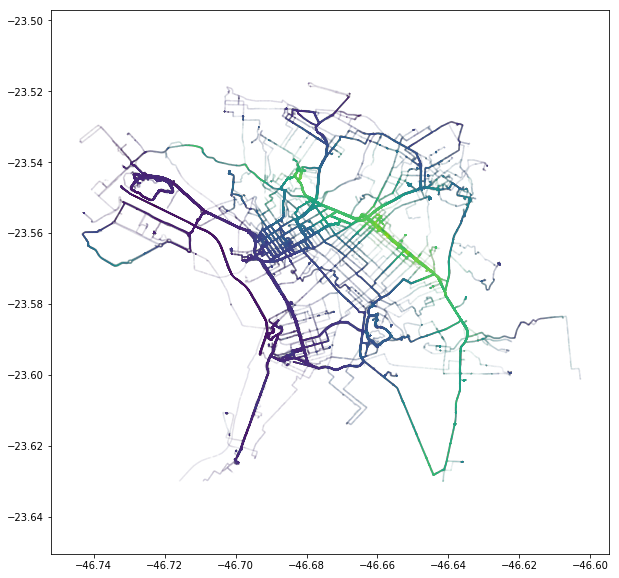

In [48]:
# segment to sao paulo area
seg = data
seg = seg[seg.latitude > -23.63] #east boundary
seg = seg[seg.latitude < -23.50] #west boundary
seg = seg[seg.longitude > -46.76] #north boundary
seg = seg[seg.longitude < -46.60] #south boundary

plt.figure(figsize=(10,10))
z = seg.elevation / max(seg.elevation) * 255
plt.scatter(seg.longitude, seg.latitude, 1, c=z[:,], alpha=0.01)
plt.axis('equal')
plt.show()
# plt.savefig('elevations600.png', dpi=600, transparent=True)
# plt.savefig('elevations600.eps', dpi=600, transparent=True)


# Understanding our type of dataset
Now that we have the crude data, we can infer other ones, like distance, velocity, acceleration, inclination, etc.
It's important to understand where to expand statistically this data. What are our limits? What questions do we want or have to answer. The ideal dataset will be a limited set of:

* Descriptive: the whole population.
* Exploratory: a random sample with many variables.
* Inferential: the right population, randomly sampled.
* Predictive: a sample population divided in training and test.
* Causal: data from a randomized study.
* Mechanistic: data about all components of the system.

It would seem ok to consider our initial data as mechanistic descriptive, but this is not true. What would be the limit of reality? We don't have all datapoints, only a fraction from an irregular readout frequency. We don't have the measures of lots of points, neither properties. They will be infered from the original points, and this is the tip to select another type.

In this study, we will better to consider our dataset as inferential. It's the right population of data because from all geopoints, it's the points that we care about: our path. It is randomly time selected, enough to consider different properties.
After infering more properties from the relationship of a smal account of variables, we will build an exploratory dataset with many more properties.

Finally, we can use this dataset as a Predictive one for use in machine learning algorithms. For a selected rider, we will try to predict it behavior on a certain point of some path.

# Looking into the data
The collected sample points are timely defined, but the precision is low, at a maximum of one second period. There are times that GPS pauses when the rider stops or simply can't tell the localization. To understand the difference between those two cases, we'll plot both delta time between points, distance, and the calculated speed.

The time is in seconds, the distance is in meters, and the speed is simply meters per second. Later will transform and use other, more common units.

The idea to detect signal failure is really simple: if it's a real stop, with pause of readings, the speed and distance will be zero or converge. But if it's a failure of sattelite signal acquirance, the speed will stay continuous with the distance growing long, or put simply, they will diverge.

In [121]:
# create a column with time deltas
data['delta_time'] = np.ediff1d(data.time, to_begin=0.)

# create a column with meters deltas
gis = np.matrix([np.roll(data.latitude, 1, 0), data.latitude, np.roll(data.longitude, 1, 0), data.longitude])
geo = pd.DataFrame(gis.T, columns=['lat1', 'lat2', 'lon1', 'lon2'])
data['distance'] = geo.apply(lambda x: great_circle((x.lat1, x.lon1), (x.lat2, x.lon2)).meters, axis = 1)
del(gis, geo)
data.loc[data.id_point==0, 'delta_time'] = 0
data.loc[data.id_point==0, 'distance'] = 0
data.head()

,elevation,id_point,id_ride,id_rider,latitude,longitude,time,delta_time,distance
0,747.7,0.0,0,0,-23.562747,-46.691410,1.496510e+09,0.0,0.000000
1,749.9,1.0,0,0,-23.562589,-46.691241,1.496510e+09,37.0,24.611158
2,750.0,2.0,0,0,-23.562554,-46.691224,1.496510e+09,2.0,4.261312
3,750.1,3.0,0,0,-23.562522,-46.691213,1.496510e+09,1.0,3.731743
4,750.2,4.0,0,0,-23.562473,-46.691212,1.496510e+09,1.0,5.451040


In [122]:
data['speed'] = data.distance / data.delta_time
data.loc[data.id_point==0, 'speed'] = 0

Make a checkpoint of the data.

In [123]:
save_data(data, "main")

In [50]:
data = load_data("main")

Let's print one ride to see it.

In [69]:
seg = data[data.id_rider==0]
seg = seg[seg.id_ride==12]
seg = seg[1:1100]

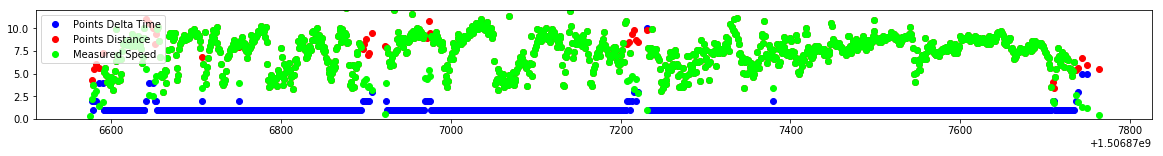

In [70]:
# this will print the sum of seconds. A greater than 2000
plt.figure(figsize=(20,2))
plt.scatter(seg.time, seg.delta_time, color="blue", label="Points Delta Time")
plt.scatter(seg.time, seg.distance, color="red", linewidth=1, label="Points Distance")
plt.scatter(seg.time, seg.speed, color="lime", linewidth=1, label="Measured Speed")

# gaussian smooth of speed
axes = plt.gca()
axes.set_ylim([0,12])
plt.legend()
plt.show()

Here we can see some signal failures: Every time the red graph shows up with too much diverging, there were lag. At slow speeds, it's normal to happen data diverging. But we can se the stops too, they are the green spikes. So, in general, in this small sample, small green spikes relate to signal failure, with greater distances between readings.

There is patterns on theses failures? Let's see.

# Speed

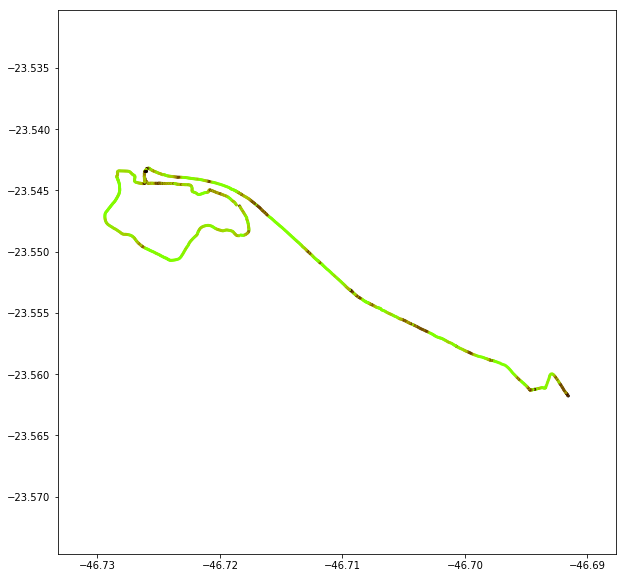

In [216]:
col = np.zeros((len(seg.speed),3))
col[:,0] = np.clip(seg.speed/8.8, 0, 1) / 360 * 90
col[:,1] = 1
col[:,2] = np.clip(seg.speed/8.8, 0, 1)

plt.figure(figsize=(10,10))
plt.scatter(seg.longitude, seg.latitude, 4, c=colors.hsv_to_rgb(col), alpha=1)
plt.axis('equal')
plt.show()
# plt.savefig('elevations600.png', dpi=600, transparent=True)
# plt.savefig('elevations600.eps', dpi=600, transparent=True)

